### Import the Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter

### Discriminator Class

- Discriminator class will be initialized by image dimension 

In [2]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
           nn.Linear(img_dim, 128),
           nn.LeakyReLU(0.1),
           nn.Linear(128,1),
           nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.disc(x)

- Since we will use MNISNT Dataset which contains images of shape (28x28x1) so our image dimension will be when we flatten the shape of the image {i.e 784}

### Generator Class

- Generator class will be inititalized by z_dim which is the dimension of the latent_noise, some image dimension

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gene = nn.Sequential(
            nn.Linear(z_dim,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            #We are using tanh() because our input is normalized between (-1 & 1) so our output should also be normalized betwenn (-1 & 1)
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.gene(x)

### Defining HyperParameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 3e-4
z_dim = 64
image_dim = 28*28*1 #(784)
batch_size = 32
num_epochs = 50

In [3]:
import os
os.makedirs("dataset", exist_ok=True)

In [5]:
disc = Discriminator(image_dim).to(device)
gene = Generator(z_dim, image_dim).to(device)
#We take fixed_noise to see the changes that has occured after training or after epochs.
#We can say it is for Visualization purposes.
fixed_noise = torch.randn((batch_size, z_dim)).to(device)  

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root="./dataset/",transform=transform, download=False)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer_disc = optim.Adam(disc.parameters(), lr=learning_rate)
optimizer_gene = optim.Adam(gene.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0


### Training Loop

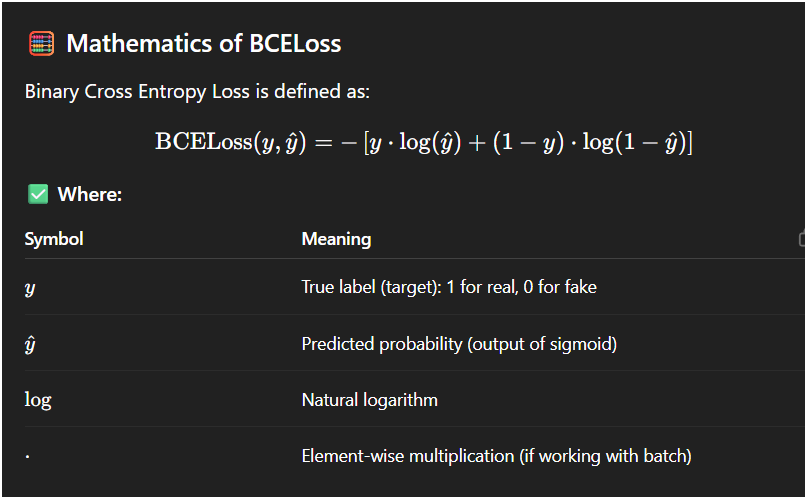

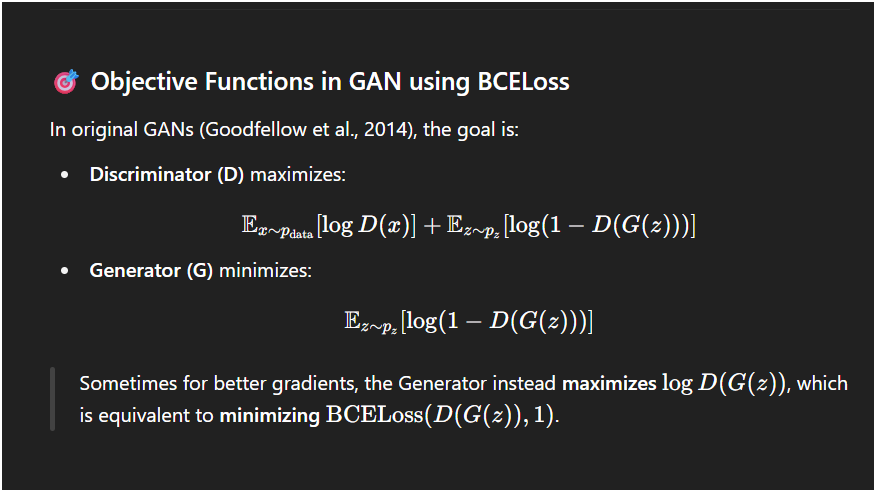

In [6]:

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(data_loader):
        #We keep only the batch_dim (i.e -1) and flatten everything else to 784
        real = real.view(-1,784).to(device)
        batch_size = real.shape[0]
        
        #Training Discriminator: TO maximize {log(D(real)) + log(1 - D(G(z)))} [z is random_noise]
        #We will train our Discriminator to:-
        #      Assign 1 to real images( D(real) )
        #      Assign 0 to fake images generated by the Generaotr ( D(G(z)) )
        # By minimizing BCELoss with the appropriate targets (1 for real, 0 for fake), the Discriminator is trained to distinguish real from fake images
        
        random_noise = torch.randn(batch_size,z_dim).to(device)
        fake_image = gene(random_noise)
        disc_real = disc(real).view(-1) #We flatten everything
        lossDisc_real = criterion(disc_real, torch.ones_like(disc_real)) #maximizing log(D(real))
        disc_fake = disc(fake_image).view(-1) 
        lossDisc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_Disc = (lossDisc_real + lossDisc_fake) /  2
        disc.zero_grad()
        loss_Disc.backward(retain_graph = True)
        optimizer_disc.step()
        
        
        #Training Generator: TO minimize log(1 - D(G(z))) <--> maximize log(D(G(z)))
        #But the log(1 - D(G(z))) leads to saturated gradients so we will maximize log(D(G(z)))
        output = disc(fake_image).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gene.zero_grad()
        lossG.backward()
        optimizer_gene.step()
        
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}]\ "
                  f"Loss Discriminator: {loss_Disc:.4f}, Loss Generator: {lossG:.4f}")
            
            with torch.no_grad():
                fake_image = gene(fixed_noise).reshape(-1,1,28,28)
                data = real.reshape(-1, 1, 28, 28)
                image_grid_fake = torchvision.utils.make_grid(fake_image, normalize=True)
                image_grid_real = torchvision.utils.make_grid(data, normalize=True)
                
                writer_fake.add_image(
                    "MNIST Fake Images", image_grid_fake, global_step=step
                )
                
                writer_real.add_image("MNIST Real Image", image_grid_real, global_step=step)
                
                step += 1 
        
        
        
         
        
        
        

<>:34: SyntaxWarning: invalid escape sequence '\ '
<>:34: SyntaxWarning: invalid escape sequence '\ '
C:\Users\athar\AppData\Local\Temp\ipykernel_11872\237582359.py:34: SyntaxWarning: invalid escape sequence '\ '
  print(f"Epoch [{epoch}/{num_epochs}]\ "


Epoch [0/50]\ Loss Discriminator: 0.7066, Loss Generator: 0.6911
Epoch [1/50]\ Loss Discriminator: 0.1937, Loss Generator: 1.9740
Epoch [2/50]\ Loss Discriminator: 0.1914, Loss Generator: 3.0074
Epoch [3/50]\ Loss Discriminator: 0.0394, Loss Generator: 4.2731
Epoch [4/50]\ Loss Discriminator: 0.0464, Loss Generator: 3.3358
Epoch [5/50]\ Loss Discriminator: 0.0180, Loss Generator: 4.7667
Epoch [6/50]\ Loss Discriminator: 0.0184, Loss Generator: 5.3681
Epoch [7/50]\ Loss Discriminator: 0.0619, Loss Generator: 5.2870
Epoch [8/50]\ Loss Discriminator: 0.1310, Loss Generator: 5.4812
Epoch [9/50]\ Loss Discriminator: 0.0506, Loss Generator: 4.2417
Epoch [10/50]\ Loss Discriminator: 0.0719, Loss Generator: 5.5802
Epoch [11/50]\ Loss Discriminator: 0.0281, Loss Generator: 5.9943
Epoch [12/50]\ Loss Discriminator: 0.0244, Loss Generator: 4.3016
Epoch [13/50]\ Loss Discriminator: 0.0052, Loss Generator: 6.0872
Epoch [14/50]\ Loss Discriminator: 0.0064, Loss Generator: 6.1838
Epoch [15/50]\ Loss 

- Save the state dictionaries 

In [14]:
torch.save(disc.state_dict(), "./weights/discriminator.pth")
torch.save(gene.state_dict(), "./weights/generator.pth")
torch.save(optimizer_disc.state_dict(), "./weights/optimizer_discriminator.pth")
torch.save(optimizer_gene.state_dict(), "./weights/optimizer_generator.pth")